<h2 style='text-align: center;'> Data Science Technology and Systems </h2>
<h3 style='text-align: center;'> Final Assignment: Predicting Airplane Delays </h3>
<h3 style='text-align: center;'> Part B – On Cloud </h3>
<h3 style='text-align: center;'> V1 - XGBoost </h3>
<h4 style='text-align: center;'> Pauline Armamento - u3246782 </h4>

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from scipy.io import arff


import os
import boto3
import sagemaker
import subprocess
from sagemaker import image_uris
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [3]:
# Load CSV files into dataframes
df1 = pd.read_csv('combined_csv_v1.csv')
df2 = pd.read_csv('combined_csv_v2.csv')

In [4]:
# Check for missing values in df1
print(df1.isnull().sum())

target             0
Distance           0
Quarter_2          0
Quarter_3          0
Quarter_4          0
                  ..
DepHourofDay_19    0
DepHourofDay_20    0
DepHourofDay_21    0
DepHourofDay_22    0
DepHourofDay_23    0
Length: 94, dtype: int64


In [5]:
# Remove rows with missing values
df1.dropna(inplace=True)

In [6]:
df1.shape

(1635590, 94)

In [7]:
# Split the data into train (70%), and then split the remaining 30% into validation (15%) and test (15%)
class_column = 'target'  # Target variable for stratified splitting

# Split the data into training (70%) and temp (30%)
train_data, temp_data = train_test_split(df1, test_size=0.3, random_state=0, stratify=df1[class_column])

# Split the temp data into validation (15%) and testing (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=0, stratify=temp_data[class_column])

# Print the shapes of the datasets
print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Testing set shape:", test_data.shape)

# Save these splits to CSV files for uploading to S3
train_file = 'train.csv'
val_file = 'validation.csv'
test_file = 'test.csv'

train_data.to_csv(train_file, index=False, header=False)
val_data.to_csv(val_file, index=False, header=False)
test_data.to_csv(test_file, index=False, header=False)


Training set shape: (1144913, 94)
Validation set shape: (245338, 94)
Testing set shape: (245339, 94)


In [8]:
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()

print("Existing buckets:")
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')


Existing buckets:
  c135321a3429026l8211909t1w50230369868-flightbucket-jxlhze9j7g8o


In [9]:
# Function to upload CSV files to S3
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Define the S3 bucket and prefix
bucket='c135321a3429026l8211909t1w50230369868-flightbucket-jxlhze9j7g8o' #change accordingly
prefix = 'flight-delay-project'

# Upload data to S3
upload_s3_csv('train.csv', 'train', train_data)
upload_s3_csv('validation.csv', 'validate', val_data)
upload_s3_csv('test.csv', 'test', test_data)

In [15]:
# Retrieve the XGBoost container
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1')


In [16]:
# Set hyperparameters for the XGBoost model
hyperparams = {
    "num_round": "42",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}


In [17]:
# Define S3 output location
s3_output_location = f"s3://{bucket}/{prefix}/output/"


In [18]:
# Create the XGBoost model estimator
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=sagemaker.Session()
)

In [19]:
# Set up the training input channels
train_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train/",
    content_type='text/csv'
)

validate_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validate/",
    content_type='text/csv'
)

# Combine channels into a dictionary
data_channels = {'train': train_channel, 'validation': validate_channel}


In [20]:
# Fit the model
xgb_model.fit(inputs=data_channels, logs=False)

print('Model training complete and ready for hosting!')

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-01-10-08-07-200



2024-11-01 10:08:09 Starting - Starting the training job..
2024-11-01 10:08:23 Starting - Preparing the instances for training...
2024-11-01 10:08:45 Downloading - Downloading input data.....
2024-11-01 10:09:16 Downloading - Downloading the training image........
2024-11-01 10:10:01 Training - Training image download completed. Training in progress........................
2024-11-01 10:12:02 Uploading - Uploading generated training model..
2024-11-01 10:12:15 Completed - Training job completed
Model training complete and ready for hosting!


In [21]:
# Hosting the model

xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-01-10-12-27-882
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-01-10-12-27-882
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-01-10-12-27-882


-------!

In [22]:
# Batch Transform

batch_X = test_data.iloc[:,1:];
batch_X.head()

,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1557415,224.0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1590263,651.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393103,1464.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624963,868.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
523747,1846.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [24]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-01-10-17-05-212
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-01-10-17-05-850


.............................................
[2024-11-01:10:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:10:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:10:24:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2024-11-01:10:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:10:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:10:24:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(

In [25]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.328043
1,0.184104
2,0.213357
3,0.132937
4,0.297319


In [26]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test_data.head(10)

      class  binary
0  0.328043       0
1  0.184104       0
2  0.213357       0
3  0.132937       0
4  0.297319       0
5  0.177061       0
6  0.188205       0
7  0.212915       0
8  0.217362       0
9  0.236984       0


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1557415,0.0,224.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1590263,0.0,651.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393103,0.0,1464.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624963,0.0,868.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
523747,1.0,1846.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364612,0.0,2139.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869896,0.0,599.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314247,1.0,1379.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
840833,0.0,1009.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
618342,0.0,1379.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
test_labels = test_data.iloc[:,0]
test_labels.head()

1557415    0.0
1590263    0.0
393103     0.0
624963     0.0
523747     1.0
Name: target, dtype: float64

In [28]:
from sklearn.metrics import confusion_matrix
import pandas as pd


matrix = confusion_matrix(test_labels, target_predicted['binary'])
matrix

array([[193819,     20],
       [ 51439,     61]])

In [29]:
df_confusion = pd.DataFrame(matrix, 
                             index=['Actual No Delay', 'Actual Delay'], 
                             columns=['Predicted No Delay', 'Predicted Delay'])
print(df_confusion)


                 Predicted No Delay  Predicted Delay
Actual No Delay              193819               20
Actual Delay                  51439               61


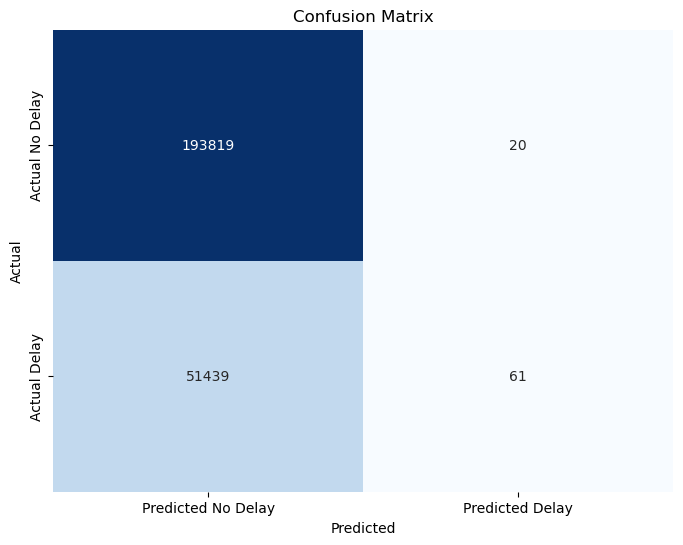

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## XGBoost Model 1 Confusion Matrix

The XGBoost Model 1, while highly accurate in predicting "No Delay" flights (correctly identifying 193,819 instances), struggles significantly with "Delay" predictions. The model misclassifies a substantial number of actual delays as "No Delay," resulting in a high false negative rate of 51,439. Although it correctly identifies 61 delay instances (true positives), this number is relatively low compared to the number of missed delays.

In [31]:
from sklearn.metrics import roc_auc_score

# Get probabilities for the positive class

y_scores = target_predicted['class']

# Calculate ROC AUC score
roc_auc = roc_auc_score(test_labels, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.6791


In [32]:
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_scores)


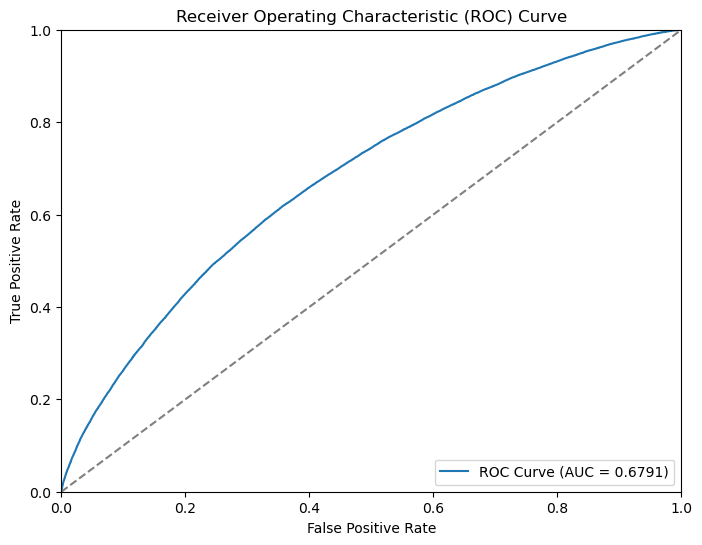

In [33]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [34]:
from sklearn.metrics import accuracy_score

# Print Accuracy
accuracy = accuracy_score(test_labels, target_predicted['binary'])
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7903


In [35]:
from sklearn.metrics import classification_report

# Create Classification Report
report = classification_report(test_labels, target_predicted['binary'], target_names=['No Delay', 'Delay'], output_dict=True)


report_df = pd.DataFrame(report).transpose()
print(report_df)


              precision    recall  f1-score        support
No Delay       0.790266  0.999897  0.882807  193839.000000
Delay          0.753086  0.001184  0.002365   51500.000000
accuracy       0.790253  0.790253  0.790253       0.790253
macro avg      0.771676  0.500541  0.442586  245339.000000
weighted avg   0.782461  0.790253  0.697990  245339.000000


Model 1 achieves a ROC AUC score of 0.6791. It performs exceptionally well in predicting "No Delay" cases, demonstrating high precision, very high recall, and a good F1-score. However, the model struggles with "Delay" cases, exhibiting low precision, very low recall, and a very low F1-score. Despite this, the model maintains an overall accuracy of 0.790253.

## XGBoost Model 1 Conclusion

While XGBoost Model 1 demonstrates strong performance in predicting "No Delay" cases, it struggles to accurately identify "Delay" instances. This class imbalance, where "No Delay" cases significantly outnumber "Delay" cases, hinders the model's ability to learn from the minority class. 

To improve the model's performance, it is crucial to address the class imbalance issue. Techniques such as undersampling or class weighting can be employed to balance the dataset and enhance the model's ability to learn from the minority class.